In [58]:
import duckdb
conn = duckdb.connect('cnpj.db')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

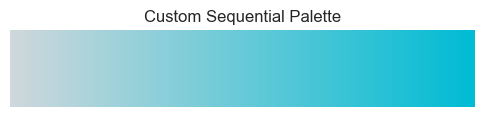

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_sequential_palette(color1, color2, n=256):
    """Create a sequential color palette."""
    cmap_segment = LinearSegmentedColormap.from_list("custom_sequential", [color1, color2], N=n)
    return cmap_segment

color1 = '#CFD8DC'
color2 = '#00BCD4'

# Create the custom sequential palette
custom_palette = create_sequential_palette(color1, color2)

# Display the palette
plt.figure(figsize=(6, 1))
plt.imshow(np.linspace(0, 100, 256)[None, :], aspect='auto', cmap=custom_palette)
plt.axis('off')
plt.title('Custom Sequential Palette')
plt.show()


In [86]:
tables = conn.execute("SHOW TABLES").fetchall()
tables = [t[0] for t in tables]
tables = [t for t in tables if not t.endswith("_raw")]
print(tables)

['cnae', 'empresas', 'estabelecimentos', 'natureza', 'simple', 'socios']


In [87]:
for table in tables:
    count = conn.execute(f"SELECT COUNT(*) FROM {table}").df().iloc[0,0]
    print(f"{table}: {count}")

cnae: 1358


empresas: 56554307
estabelecimentos: 59495407
natureza: 89
simple: 38371644
socios: 23765603


# Question 1
## How many companies there registed in brazil until last year?

In [89]:
companies_bys_year = conn.execute("""SELECT left(activity_start_date, 4) AS year
                                  , COUNT(*) AS new_companies
                                  , SUM(COUNT(*)) OVER (ORDER BY year) AS total_companies
                                    FROM ESTABELECIMENTOS
                                    WHERE identifier IN (1)
                                    GROUP BY year
                                    ORDER BY year DESC;""").df()
#remove last year because it is not complete
companies_bys_year = companies_bys_year.iloc[1:]
companies_bys_year.head(5)

,year,new_companies,total_companies
1,2023,3852651,56062893.0
2,2022,3855778,52210242.0
3,2021,4019863,48354464.0
4,2020,3915072,44334601.0
5,2019,3167006,40419529.0


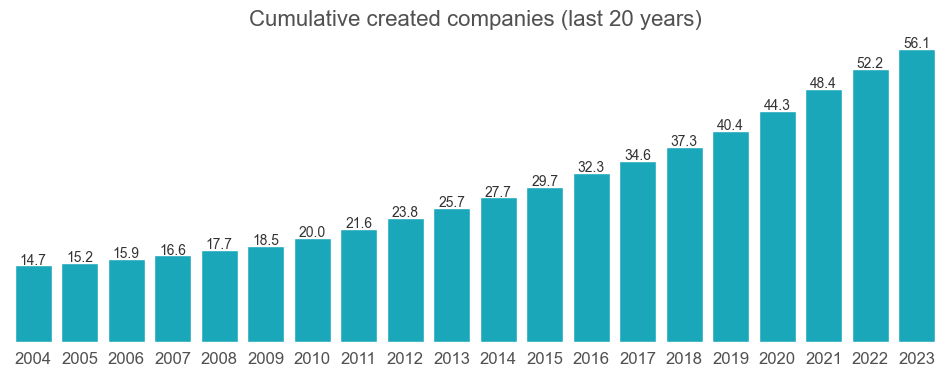

In [96]:
# plotting the time series of cumulative companies created per year
plot_df = companies_bys_year.copy().head(20).sort_values('year', ascending=True).reset_index()

plot_df["total_companies"] = (plot_df["total_companies"] / 1000000).round(1)
# converting year to datetime
plot_df['year'] = pd.to_datetime(plot_df['year']).dt.year

# Plotting the time series of companies created per year
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.barplot(data=plot_df,  y='total_companies',x='year', color=color2)
plt.title("Cumulative created companies (last 20 years)", fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)

for index, row in plot_df.iterrows():
    plt.text(row.name, row.total_companies + 0.2, str(row.total_companies), color='black', ha="center", fontsize=10, alpha=0.8)

# Question 2
## How many each year?

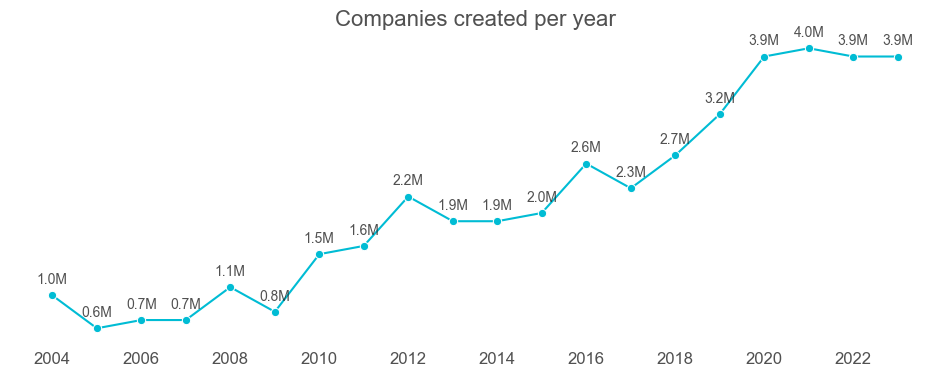

In [91]:
# Plotting time series of companies created per year

plot_df = companies_bys_year.copy().head(20)
plot_df["new_companies"] = (plot_df["new_companies"] / 1000000).round(1)
# converting year to datetime
plot_df['year'] = pd.to_datetime(plot_df['year'])
# Plotting the time series of companies created per year



plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.lineplot(data=plot_df, x='year', y='new_companies', marker='o', color=color2)
plt.title("Companies created per year", fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8);
plt.box(False)

# Adding data labels
for index, row in plot_df.iterrows():
    plt.text(row['year'], row['new_companies'] + 0.1, f'{row["new_companies"]}M', ha = 'center', va = 'bottom', fontsize=10, alpha=0.8)
plt.show()



# Question 3
## How many are still active?

In [92]:
companies_bys_status = conn.execute("""SELECT 
                                        CASE 
                                            WHEN registration_status = 1 THEN 'NULL'
                                            WHEN registration_status = 2 THEN 'ACTIVE'
                                            WHEN registration_status = 3 THEN 'SUSPENDED'
                                            WHEN registration_status = 4 THEN 'INACTIVE'
                                            WHEN registration_status = 8 THEN 'CLOSED'
                                        END AS status_name,
                                        COUNT(*) AS companies_count,
                                        ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER (), 1) AS percentage,
                                    FROM 
                                        ESTABELECIMENTOS 
                                    GROUP BY 
                                        ALL
                                    ORDER BY 
                                        companies_count DESC;""").df()
companies_bys_status.head(5)

,status_name,companies_count,percentage
0,CLOSED,26672875,44.8
1,ACTIVE,23536635,39.6
2,INACTIVE,8929908,15.0
3,SUSPENDED,263517,0.4
4,NULL,92472,0.2


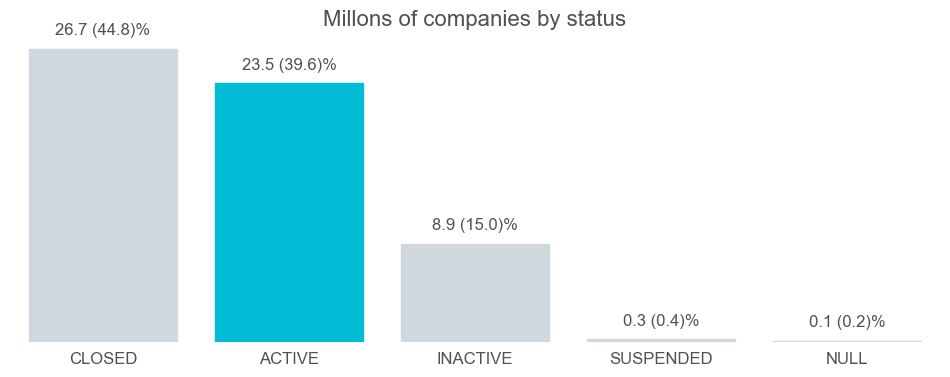

In [93]:
# Plotting the distribution of companies by status adding data labels and removing the grid lines, y-axis labels and canvas border
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.barplot(data=companies_bys_status, x='status_name', y='companies_count', legend=False)

# cooring the bar that represents the active companies and all the other bars in gray
active_index = companies_bys_status[companies_bys_status['status_name'] == 'ACTIVE'].index[0]
for i in range(companies_bys_status.shape[0]):
    if i != active_index:
        plt.gca().get_children()[i].set_color(color1)
    else:
        plt.gca().get_children()[i].set_color(color2)

plt.title('Millons of companies by status', fontsize=16, alpha=0.8)
# Adding the data labels
for i in range(companies_bys_status.shape[0]):
    count = companies_bys_status.iloc[i]['companies_count'] 
    percentage = companies_bys_status.iloc[i]['percentage']
    plt.text(i, count + 10**6, f'{round(count/1000000,1)} ({percentage})%', ha = 'center', va = 'bottom', fontsize=12, alpha=0.8)
#removing y-axis labels and text
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)
plt.show()

# Question 4
## Here are those active companies?

In [142]:
active_companies_by_state = conn.execute("""SELECT
                                     state
                                    , COUNT(*) AS companies_count
                                    , ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER ()) AS percentage
                                FROM
                                    ESTABELECIMENTOS
                                WHERE
                                    state <> 'EX' AND identifier = 1 AND registration_status = 2
                                GROUP BY
                                     state
                                HAVING 
                                    companies_count > 1
                                ORDER BY
                                    companies_count DESC
                               ;""").df()
active_companies_by_state.head(5)

,state,companies_count,percentage
0,SP,6758941,30.0
1,MG,2356966,11.0
2,RJ,1901163,9.0
3,PR,1590832,7.0
4,RS,1438637,6.0


/var/folders/5l/rw2smw3x7p1_g2r7qggpzqkh0000gn/T/ipykernel_98850/1003188781.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, percentage, state in zip(brazil.geometry.centroid.x, brazil.geometry.centroid.y, brazil['companies_count'], brazil['percentage'], brazil['state']):


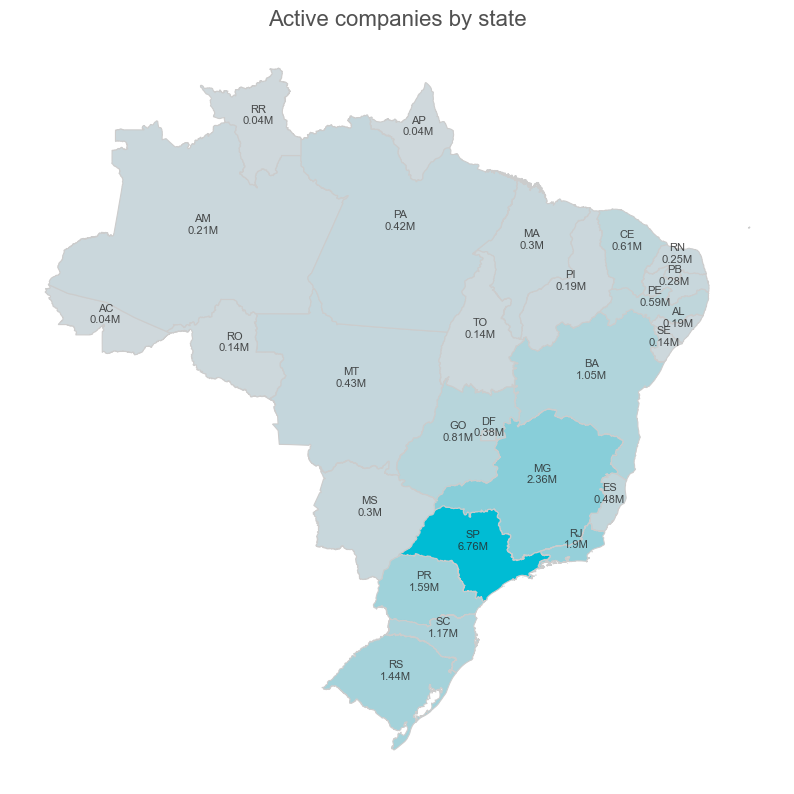

In [144]:
#plotting the distribution of active companies by state in a brazilian map
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# loading the brazilian states shapefile, available at https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson
brazil = gpd.read_file('brazil-states.geojson')
 
# merging the shapefile with the active companies by state
brazil = brazil.merge(active_companies_by_state, left_on='sigla', right_on='state')
brazil['companies_count'] = (brazil['companies_count']/10**6).round(2)

# creating the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plotting the brazilian states
brazil.plot(column='companies_count', cmap=custom_palette, linewidth=0.8, ax=ax, edgecolor='0.8')
# removing the axis
ax.axis('off')
# setting the title
ax.set_title('Active companies by state', fontdict={'fontsize': '16', 'fontweight' : '3'}, alpha=0.8)

# Adding the data labels
for x, y, label, percentage, state in zip(brazil.geometry.centroid.x, brazil.geometry.centroid.y, brazil['companies_count'], brazil['percentage'], brazil['state']):
    ax.text(x, y, f'{state}\n{label}M', ha='center', fontsize=8, alpha=0.8)

# Question 4
# What are the most common activities of the companies in Brazil?

In [466]:
most_common_activities = conn.execute("""SELECT
                                       state,
                                        c.description AS activity
                                        , COUNT(*) AS companies_count
                                        , ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER (), 5) AS percentage
                                    FROM
                                        estabelecimentos e
                                    INNER JOIN
                                        cnae c ON e.main_activity = c.code
                                    WHERE
                                        e.identifier = 1 AND e.registration_status = 2 AND e.state <> 'EX'
                                    GROUP BY
                                        1,2
                                    ORDER BY
                                        companies_count DESC;""").df()

most_common_activities = conn.execute("""SELECT *, 
                                        SUM(percentage) OVER (ORDER BY companies_count DESC) AS cumulative_percentage,
                                      -- rank of the activity per state
                                        RANK() OVER (PARTITION BY state ORDER BY companies_count DESC) AS rank
                                    FROM
                                        most_common_activities;                                      
                                      """).df()

most_common_activitiy_per_state = conn.execute("""SELECT CASE WHEN regexp_matches(activity, 'Comércio','i') THEN 'COMMERCE' ELSE 'OTHER' END AS category
                                               , string_agg(state, ', ') AS states, count(*) AS states_count
                                               , FIRST(activity) AS most_common_activity
                                    FROM most_common_activities
                                    WHERE rank = 1
                                    GROUP BY category
                                    ORDER BY 3 DESC;""").df()

In [470]:
pd.options.display.max_colwidth = 50
most_common_activitiy_per_state

,category,states,states_count,activity
0,COMMERCE,"AL, RN, SP, PA, RS, MG, TO, ES, PB, AC, PR, SC...",25,Comércio varejista de artigos do vestuário e a...
1,OTHER,"DF, RJ",2,"Cabeleireiros, manicure e pedicure"


In [578]:
activites_representative_range = most_common_activities['percentage_range'] = most_common_activities['percentage'].apply(lambda x: '0-0.01%' if x <= 0.0001 else '0.01-0.1%' if x <= 0.001 else '0.1-1%' if x <= 0.01 else '1-10%' if x <= 0.1 else '10-100%')
# count activities and sum the percentage by percentage range
activites_representative_range = most_common_activities.groupby('percentage_range').agg({'activity': 'count', 'percentage': 'sum'}).reset_index()

# adding the cumulative percentage

activites_representative_range['cumulative_percentage'] = activites_representative_range['percentage'].cumsum().round(1)
activites_representative_range['percentage_activity'] = (activites_representative_range['activity'] / activites_representative_range['activity'].sum() * 100).round(1).sort_values(ascending=False)
activites_representative_range



,percentage_range,activity,percentage,cumulative_percentage,percentage_activity
0,0-0.01%,13038,0.41240,0.4,44.3
1,0.01-0.1%,9101,3.50659,3.9,30.9
2,0.1-1%,5539,18.43887,22.4,18.8
3,1-10%,1622,44.28839,66.6,5.5
4,10-100%,152,33.33946,100.0,0.5


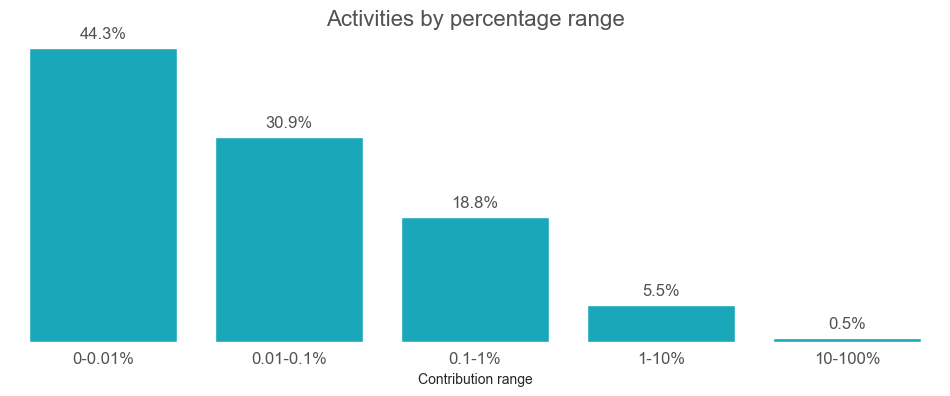

In [585]:


#plotting the distribution of activities by percentage range
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.barplot(data=activites_representative_range, x='percentage_range', y='percentage_activity', color=color2)
plt.title('Activities by percentage range', fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('')
plt.xlabel('Contribution range')
plt.yticks([])
# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)


# Adding the data labels
for i in range(activites_representative_range.shape[0]):
    count = activites_representative_range.iloc[i]['activity'] 
    percentage = activites_representative_range.iloc[i]['percentage_activity']
    plt.text(i, percentage + 1, f'{percentage}%', ha = 'center', va = 'bottom', fontsize=12, alpha=0.8)

plt.show()



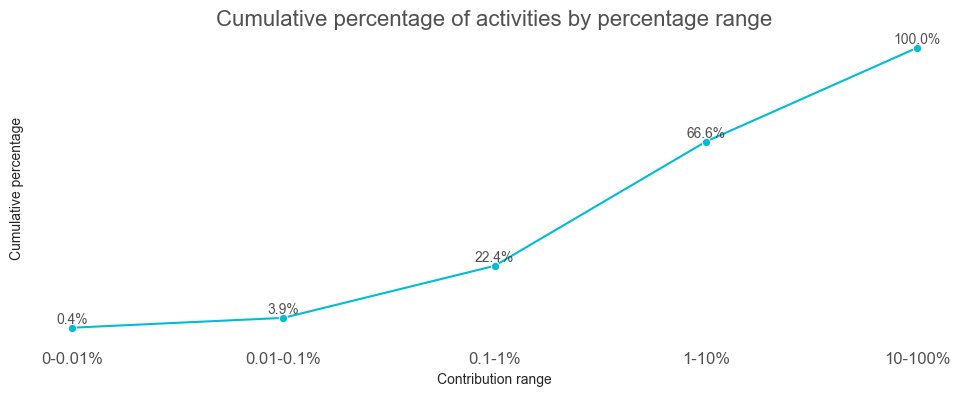

In [586]:
#plot cumulative sum of activities by percentage range
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.lineplot(data=activites_representative_range, x='percentage_range', y='cumulative_percentage', marker='o', color=color2)
plt.title('Cumulative percentage of activities by percentage range', fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('Cumulative percentage')
plt.xlabel('Contribution range')
plt.yticks([])

# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)


#adding data labels
for index, row in activites_representative_range.iterrows():
    plt.text(row.name, row.cumulative_percentage + 0.5, f'{row.cumulative_percentage}%', ha = 'center', va = 'bottom', fontsize=10, alpha=0.8)


plt.show()
